# IRFs using Proxy SVAR with RR2004 as external instrument

In [7]:
import pandas as pd
import numpy as np

## OLS Function

In [8]:
def OLS(X,y,p):
    
    T = y.shape[0]
    K = y.shape[1]
    
    # Obtain the coefficients using the OLS formula (X^T*X)^(-1)*X^T*y
    A1 = np.matmul(X.T,X)
    A = np.linalg.inv(A1)
    B = np.matmul(X.T,y) # This is the Cov(X,y) = E(Xy)
    coefficients = np.matmul(A,B)
    
    # Compute fitted values and residuals
    y_hat = np.matmul(X,coefficients)
    residuals = y - y_hat
    
    # Compute the variance of the residuals
    residuals_squared = np.matmul(residuals.T,residuals)
    Sigma = residuals_squared / (T - K*p - 1)
    
    return coefficients, residuals, Sigma, B


## Function to obtain shocks and IRFS

In [9]:
def doProxySVAR(Y,Proxy,p,irf_h):
    
    T, K = Y.shape
    
    X = [Y.shift(i) for i in range(1, p+1)]
    X = pd.concat(X, axis=1)
    X = X.iloc[p+1:,:]
    X.reset_index(drop=True, inplace=True)
    X = X.to_numpy()
    X = np.hstack((np.ones((len(X), 1)), X))  # Add column of ones (i.e. a constant for the regression).

    Y = Y.iloc[p+1:,:]
    Y.reset_index(drop=True, inplace=True)
    Y = Y.to_numpy()

    Proxy = Proxy.iloc[p+1:]                      # Need to remove the first observation since we lagged Y and lost one observation.
    Proxy.reset_index(drop=True, inplace=True)  # Reset index, since we lost first observation.
    Proxy = Proxy.to_numpy()                    # Again, in order to be able to use the OLS function we have created.
    Proxy = Proxy.reshape(len(Y),1)             # Fix dimensions for later appropiate matrix multiplication.
    m = np.hstack((np.ones((len(Proxy), 1)), Proxy))  # Add column of ones (i.e. a constant for the regression).
    
    beta, residuals, Sigma, _ = OLS(X,Y,p)
    
    # Identification
    u = residuals                                     # Just renaming to follow the notation.

    ## Regress the residuals on the proxy and obtain \Sigma_mu
    _, _, _, Sigma_mu = OLS(m,u,1)

    ## Get \tilde{s}_{2:n,1} = E(m_t u_{2:n,t}) / E(m_t u_{1,t})
    s_tilde_2n = Sigma_mu[1,1:] / Sigma_mu[1,0]

    s12A = Sigma[1:,0] - s_tilde_2n * Sigma[0,0]
    s12B = Sigma[1:,1:] - (s_tilde_2n * Sigma[0,1:] + Sigma[1:,0].reshape(4,1) @ s_tilde_2n.reshape(4,1).T)

    s12s12T = s12A.T @ np.linalg.inv(s12B) @ s12A    # @ is a shortcut for np.matmul().

    s11 = np.sqrt(Sigma[0,0] - s12s12T)

    s1 = np.hstack((s11, s_tilde_2n * s11))
    s1 = s1.reshape(K,1) # Just reshape to have the correct dimensions

    identified_shock = s1.T @ np.linalg.inv(Sigma) @ u.T
    identified_shock = identified_shock.T
    
    # IRFs
    IR = np.zeros((irf_h + p + 1,K))

    IR[p+1,:] = s1[:,0] / s11

    for jj in range(2,irf_h+1):
        lvars = IR[p+jj-1:jj-1:-1,:]
        IR[p+jj,:] = lvars.flatten().reshape(1,K*p) @ beta[1:p*K+1,:]

    IR = IR[p+1:,:]
    
    return identified_shock, IR


In [10]:
# Load Ramey (2016) Monetary Policy data
data = pd.read_excel('data/Ramey_data.xlsx', sheet_name='Monthlydat6996')
data['LIP'] = data['LIP'] * 100      # x 100 as done in Ramey
data['LCPI'] = data['LCPI'] * 100    # x 100 as done in Ramey

p = 12 # Number of lags for the VAR(p) model
irf_h = 48 # Number of periods for IRF

# From all the data, are only interested in some variables
Y = data[['FFR', 'LIP', 'UNEMP','LCPI','LPCOM']]
Proxy = data['RRORIG']

MP_shock, IRF = doProxySVAR(Y,Proxy,p,irf_h)

## Plot Monetary Policy Shock

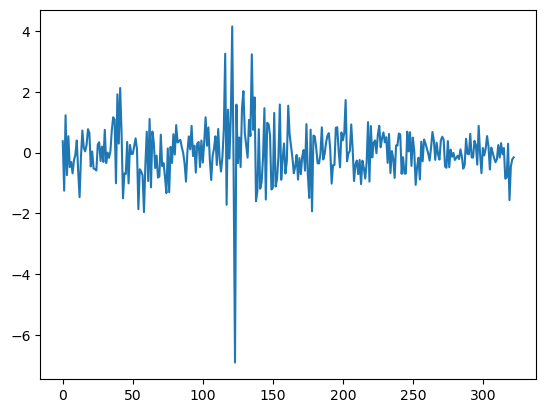

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(MP_shock)),MP_shock)

## Plot IRFs

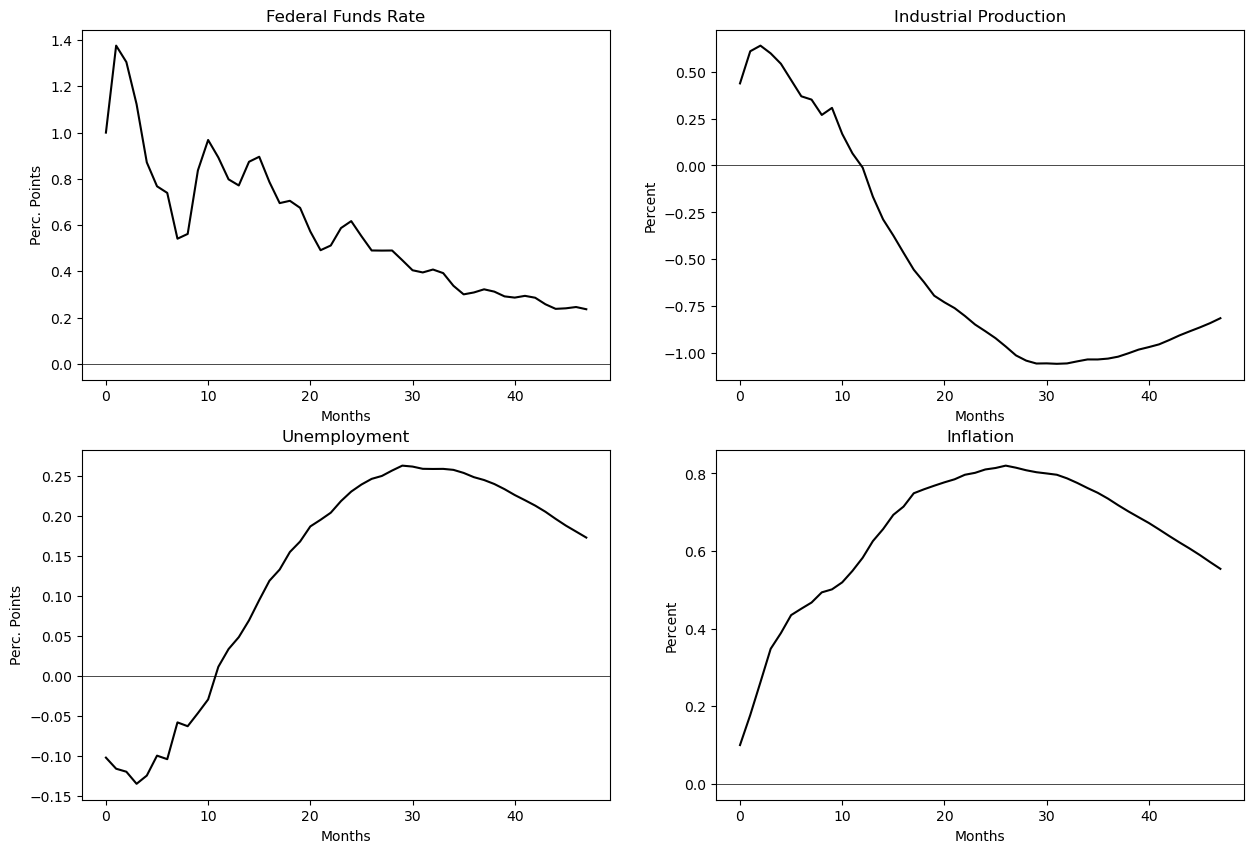

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].plot(np.arange(irf_h), IRF[:,0], color='black')
axs[0,0].axhline(0, color='black', linewidth=0.5)
axs[0,0].set_xlabel('Months')
axs[0,0].set_ylabel('Perc. Points')
axs[0,0].set_title('Federal Funds Rate')

axs[0,1].plot(np.arange(irf_h), IRF[:,1], color='black')
axs[0,1].axhline(0, color='black', linewidth=0.5)
axs[0,1].set_xlabel('Months')
axs[0,1].set_ylabel('Percent')
axs[0,1].set_title('Industrial Production')

axs[1,0].plot(np.arange(irf_h), IRF[:,2], color='black')
axs[1,0].axhline(0, color='black', linewidth=0.5)
axs[1,0].set_xlabel('Months')
axs[1,0].set_ylabel('Perc. Points')
axs[1,0].set_title('Unemployment')

axs[1,1].plot(np.arange(irf_h), IRF[:,3], color='black')
axs[1,1].axhline(0, color='black', linewidth=0.5)
axs[1,1].set_xlabel('Months')
axs[1,1].set_ylabel('Percent')
axs[1,1].set_title('Inflation')

plt.show()